In [1]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_adv, GRF_pos
from datasets import advection_solver
from utils.func import periodic
from utils.PDETriple import PDETripleCartesianProd
from utils.pdes import advection_equation

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
# dde.config.set_random_seed(2023)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
total_training_vx = 300
ls = 0.5
testing_path = f"datasets/ADV_100_{ls:.2f}_101_101.npz"

start_num = 100
check_num = 100
select_num = 20

lr_start = 1e-3
lr_middle = 1e-3
lr_end = 1e-3

iter_start = 10000
iter_middle = 10000
iter_end = 10000

batch_start = lambda n: n // 5
batch_middle = lambda n: n // 5
batch_end = lambda n: n // 5

decay_start = ("step", 2500, 0.5)
decay_middle = ("step", 2500, 0.5)
decay_end = ("step", 2500, 0.5)

if False:
    makeTesting_adv(length_scale = ls)

In [3]:
space = GRF_pos(1.0, length_scale = ls, N= 1000, interp="cubic")
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(start_num), np.linspace(0, 1, 101)[:, None])
# vxs = vxs - vxs.min(axis = 0, keepdims = True) + 0.5
xt, uxts = advection_solver(vxs)
grid = xt.reshape(101 * 101, -1)
uxts = uxts.reshape(-1, 101 * 101)

(100, 1000)


In [4]:
train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(testing_path)
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(100, 101) (10201, 2) (100, 10201)
(100, 101) (10201, 2) (100, 10201)


In [5]:
def dirichlet(inputs, outputs):
    xt = inputs[1]
    x, t = xt[None, :, 0], xt[None, :, 1]
    return 4 * x * t * outputs + (torch.pi * x).sin() + (torch.pi * t / 2).sin()  

def act(inputs, outputs):
    return outputs.sigmoid()

data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 256, 256, 256],
    [2, 256, 256, 256],
    "gelu",
    "Glorot normal",
)

net.apply_output_transform(dirichlet)
# net.apply_output_transform(act)

# pre-train
model = dde.Model(data, net)
model.compile("adam", 
              lr= lr_start, 
              loss= ["mse"], 
              metrics = ["mean l2 relative error"], 
              decay = decay_start)

Compiling model...
'compile' took 0.001822 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [7.81e-01]    [7.93e-01]    [1.40e+00]    
1000      [2.91e-02]    [2.93e-02]    [2.60e-01]    
2000      [1.27e-02]    [1.33e-02]    [1.74e-01]    
3000      [9.48e-03]    [8.49e-03]    [1.39e-01]    
4000      [6.01e-03]    [6.22e-03]    [1.18e-01]    
5000      [5.78e-03]    [4.98e-03]    [1.05e-01]    
6000      [3.28e-03]    [3.76e-03]    [9.11e-02]    
7000      [3.53e-03]    [3.47e-03]    [8.72e-02]    
8000      [2.89e-03]    [3.18e-03]    [8.32e-02]    
9000      [2.55e-03]    [3.07e-03]    [8.19e-02]    
10000     [2.46e-03]    [2.95e-03]    [8.04e-02]    

Best model at step 10000:
  train loss: 2.46e-03
  test loss: 2.95e-03
  test metric: [8.04e-02]

'train' took 169.446106 s



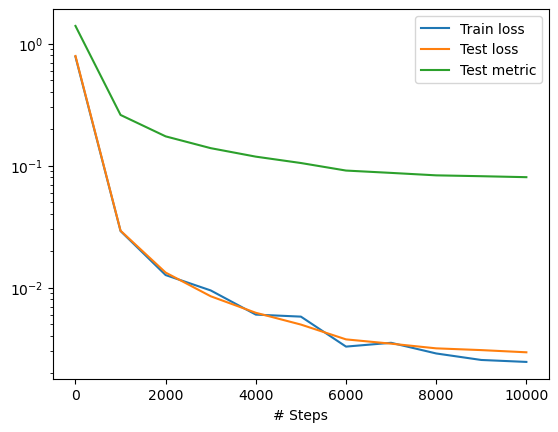

In [6]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

losshistory.to_pandas().to_csv(f"results/adv_{date}_rasg.csv", index=False)

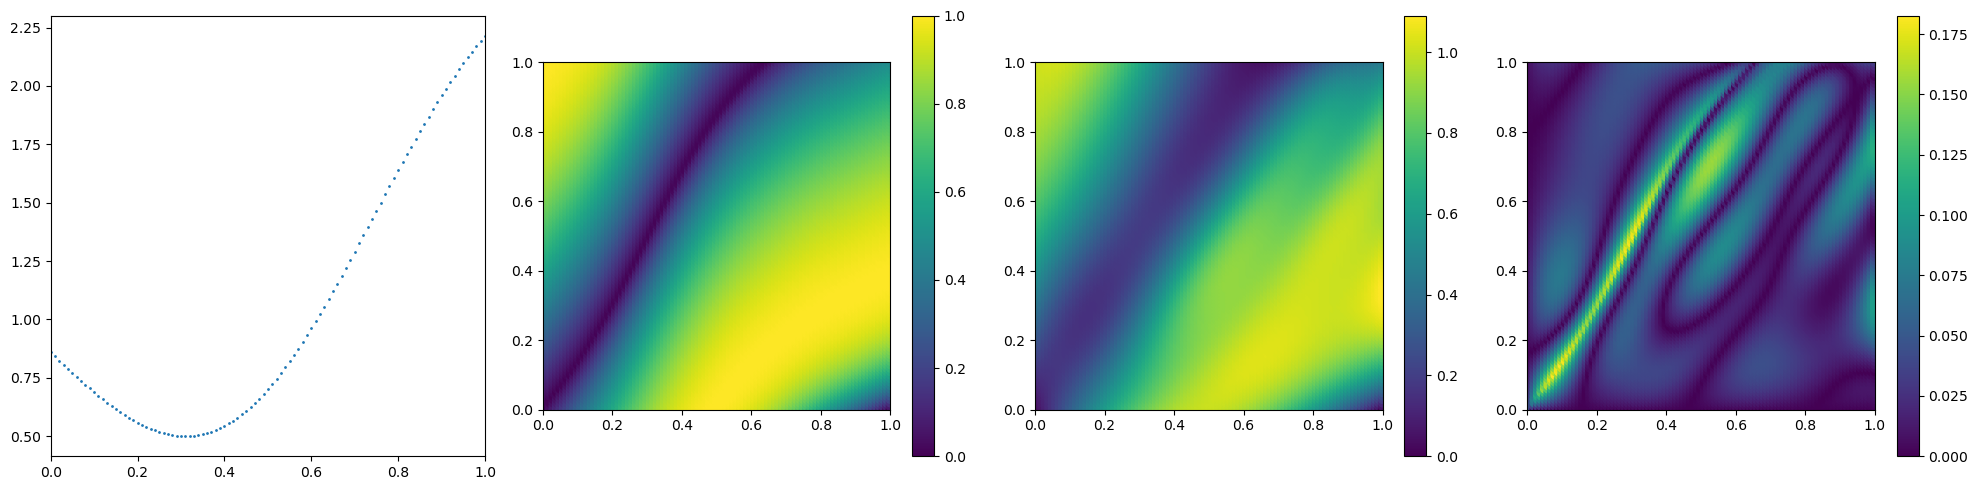

In [7]:
i = 0
# plot-data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,5))

v = train_vxs[i]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = train_uxts[i]
xt = train_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)
colorbar = fig.colorbar(ax2.scatter(xt[...,0], xt[...,1], c=ut), ax=ax2)

out = model.predict((train_vxs[(i,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)
colorbar = fig.colorbar(ax3.scatter(xt[...,0], xt[...,1], c=out), ax=ax3)

ax4.set_xlim(0,1)
ax4.set_ylim(0,1)
ax4.set_aspect('equal')
ax4.scatter(xt[...,0], xt[...,1], c=ut-out)
colorbar = fig.colorbar(ax4.scatter(xt[...,0], xt[...,1], c=np.abs(ut-out)), ax=ax4)

plt.tight_layout()
plt.show()

In [8]:
xt[0], ut[0]

(array([0., 0.], dtype=float32), 0.0)

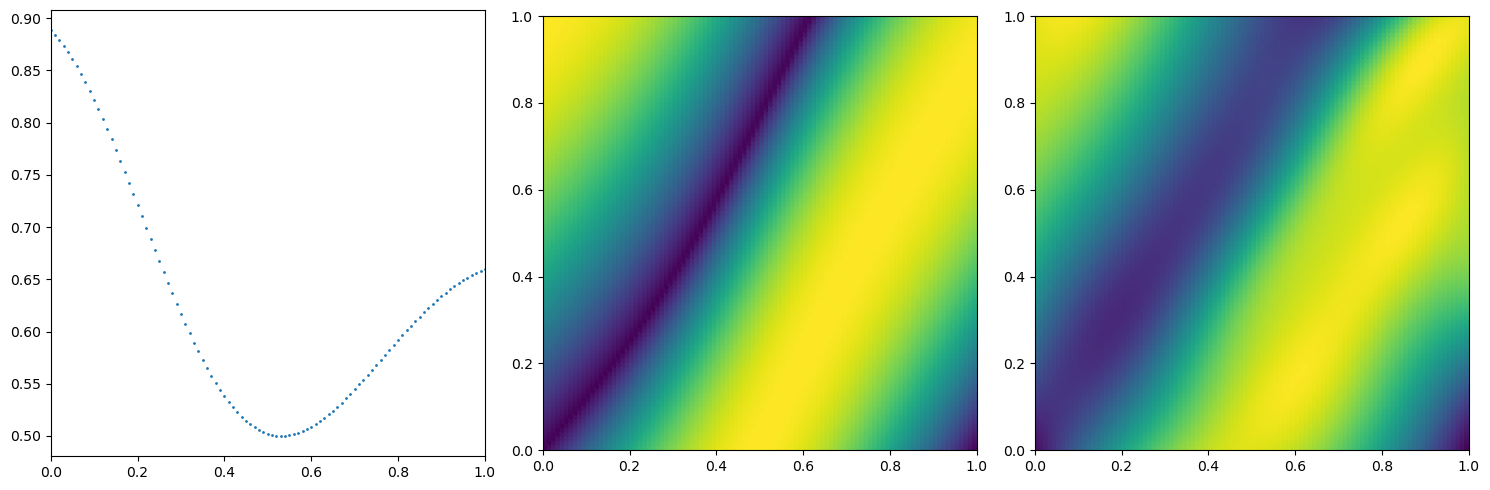

In [9]:
# plot-data
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))

v = test_vxs[3]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = test_uxts[3]
xt = test_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)

out = model.predict((test_vxs[(3,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)

plt.tight_layout()
plt.show()

In [10]:
# tune
while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, advection_equation, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = GRF_pos(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, check_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    (vxs, xts), _, c = testing_new_data.train_next_batch()
    out = model.predict((vxs, xts), aux_vars = c, operator = advection_equation)
    
    res = np.mean(np.abs(out), axis = 1)
    print(np.mean(res), np.std(res))
    select_num = min(select_num, total_training_vx - len(train_vxs))
    topk_index = np.argpartition(res, -select_num)[-select_num:] # select the top 20 vxs
    # print(res, topk_index, res[topk_index])
    topk_vxs = vxs[topk_index]
    xt, uxts = advection_solver(topk_vxs)
    uxts = uxts.reshape(-1, 101 * 101)
 
    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])
    
    # tune-train
    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam", 
                  lr = lr, 
                  metrics = ["mean l2 relative error"],
                  decay = decay,)

    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/adv_{date}_rasg.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/adv_{date}_rasg.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()
    
torch.save(model.state_dict(), f"results/adv_model_{date}_rasg.pth")

(100, 1000)


KeyboardInterrupt: 